# Quick Start Guide

This notebook will help you to get up and running with the basic functions of the ``freealg`` package. If you have not already done so, you can install ``freealg`` by running ``pip install .`` in the root directory of this repository. All plotting utilities support LaTeX, so we will set the flag ``latex=True``. If plots do not work on your system, consider turning this flag off. 

In [1]:
import numpy
latex = True

``freealg`` has support for several classes of matrix ensembles out of the box. These includes the Wishart ensemble, comprising matrices of size $n \times n$ given by
$$A = d^{-1} XX^\top, \text{ where } X \in \mathbb{R}^{n \times d}.$$
As $n, d \to \infty$ with the aspect ratio $\lambda = \frac{n}{d}$ constant, the distribution of eigenvalues converges to the Marchenko--Pastur law. This ensemble is accessible under the ``MarchenkoPastur`` class in ``freealg.distributions``.

First, we will generate a matrix of size $3000 \times 3000$ with aspect ratio $\lambda = \frac{1}{50}$. Depending on your machine, this could take a while...

In [2]:
from freealg.distributions import MarchenkoPastur

mp = MarchenkoPastur(1/50)
A = mp.matrix(3000)

Now, compute its eigenvalues using the standard NumPy solver ``numpy.linalg.eigvalsh``. 

In [3]:
eig = numpy.linalg.eigvalsh(A)

Alternatively, we can use the ``eigfree`` command to quickly estimate the eigenvalues of $A$. 

In [6]:
from freealg import eigfree

eig_est = eigfree(A)

We can compare the accuracy in this approximation to the real eigenvalues. This is a randomized algorithm, so the accuracy can vary, but the distributions should typically match up quite well.

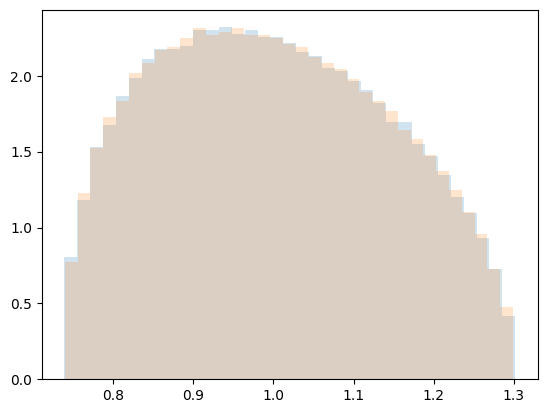

In [7]:
import matplotlib.pyplot as plt

num_bins = 35
plt.hist(eig,     bins = num_bins, alpha = 0.2, density=True)
plt.hist(eig_est, bins = num_bins, alpha = 0.2, density=True)
plt.show()

The log-determinants can also be computed and compared. Again, your mileage may vary, especially for small matrix sizes like this where accuracy tends to be low.

In [8]:
print('Log-determinant (exact):', numpy.sum(numpy.log(eig)))
print('Log-determinant (free) :', numpy.sum(numpy.log(eig_est)))

Log-determinant (exact): -30.390930290902503
Log-determinant (free) : -30.221445130910524


``freealg`` is not really designed for matrices of size $3000 \times 3000$ though! The primary advantage of ``eigfree`` is that we can use our matrix $A$ to estimate the spectrum of a Wishart matrix containing $A$ that is of much larger size, say $100,000 \times 100,000$. This is much closer to the asymptotic limit where 

In [15]:
eig_big = eigfree(A, N=100_000)

**This only took a few seconds!** Such a matrix would be _far_ too large to compute eigenvalues for. Fortunately, we know that the spectral density of this matrix should correspond to the Marchenko-Pastur law with the aspect ratio changed to $\lambda = \frac{100000}{50 \times 3000}$. Using the density utility for the ``MarchenkoPastur`` class, we can compare the theoretical density with that obtained by ``eigfree``.

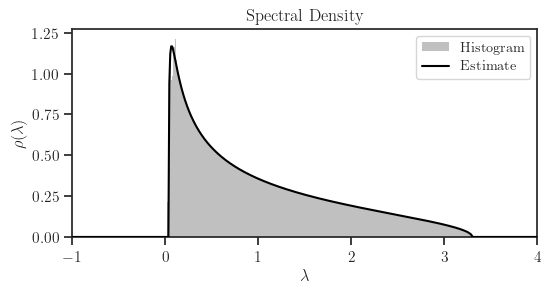

In [16]:
mp_big = MarchenkoPastur(1/50 * 100_000 / 3000)
rho = mp_big.density(plot=True, latex=latex, eig=eig_big)

### The FreeForm Class

``eigfree`` is convenient for estimating eigenvalues, but some situations may require some additional finetuning to get a good fit. Fortunately, there are many settings and diagnostics available for this purpose using the ``FreeForm`` class. This is the central class in ``freealg``; the procedure ``eigfree`` is merely a wrapper around its functionality. Let's walk through some of what we can do.

First, we construct the ``FreeForm`` object. In this case, since we know the support of the spectral density explicitly, we can pass that in as an argument. This is one less object that we need to approximate!

In [4]:
from freealg import FreeForm

ff = FreeForm(eig, support=(mp.lam_m, mp.lam_p))

Before we can do anything with ``FreeForm``, we first need to fit the spectral density. This is achieved using the ``.fit()`` function. There are many available arguments to this function, so be sure to take a look at the documentation to see what they do.

As an example, we will fit the spectral density using Jacobi polynomials; these are much more versatile than the Chebyshev polynomials used by default in ``eigfree``. By passing the ``plot=True`` command, we can visualize a few useful diagnostics for the fitting procedure. The left plot shows the spectral energy per mode in the series expansion; this should decrease steadily with $k$. An oscillating plot here is indicative of a bad fit.

The second plot shows the approximation of the glue function. Simply put, the two lines here should be on top of each other. Any visible deviation will likely result in significant error when expanding to larger matrices.

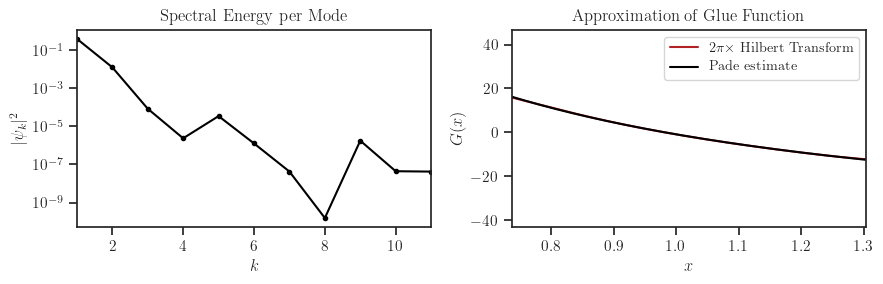

In [5]:
psi = ff.fit(method='jacobi', K=10, alpha=0.5, beta=0.5, reg=0, projection='gaussian', kernel_bw=0.1,
             damp='jackson', force=False, pade_p=0, pade_q=1, odd_side='left', pade_reg=0,
             optimizer='ls', plot=True, latex=latex)

Now we can compute and plot the estimated spectral density using the built-in ``.density()`` procedure. The density should be smooth and match the histogram well. Sporadic oscillations or significant deviations from the histogram is a sign of a bad fit!

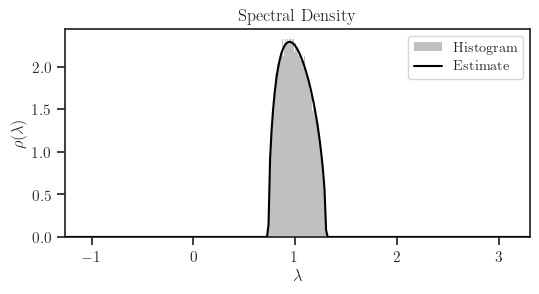

In [6]:
x = numpy.linspace(mp.lam_m-2, mp.lam_p+2, 300)
rho = ff.density(x, plot=True, latex=latex)

The Hilbert transform of the density plays a prominent role in performing our free decompression algorithm. It can be evaluated and plotted using the ``.hilbert()`` command. This plot is less useful for diagnosing errors, but nonetheless, we are looking for a relatively smooth function with two cusps at the edges of the support (marked by $\lambda_\pm$).

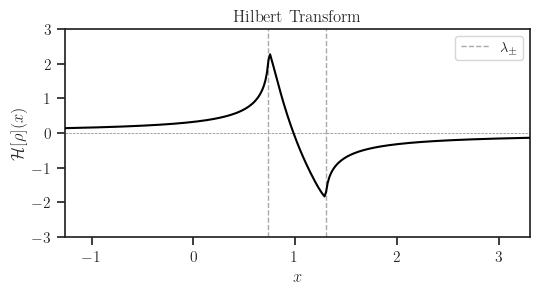

In [7]:
hilb = ff.hilbert(x, rho, plot=True, latex=latex)

The most important object, however, is the **Stieltjes transform**. This is a function on the complex plane, and requires some more sophisticated plotting techniques, commonly in terms of the magnitude and phase. The Stieltjes transform can be evaluated and plotted using the ``.stieltjes()`` command. If ``plot=True`` or ``y`` is not ``None``, the function will evaluate the Stieltjes transform on a 2D Cartesian grid. Otherwise, the Stieltjes transform will be evaluated over the arguments provided, which may be complex-valued.

There are two branches of the Stieltjes transform, and hence two outputs are returned from the function. The first is the *principal branch*, which has a branch cut on the real axis over the support of the density. This is useful for purposes in random matrix theory, but is not useful for free decompression. The *secondary branch* is equal to the principal branch on the upper half plane, but is analytic over the same region as the branch cut of the principal branch. You should see a nice pink curve passing straight through here. This curve is where the magic happens, so it's very important that it looks smooth!

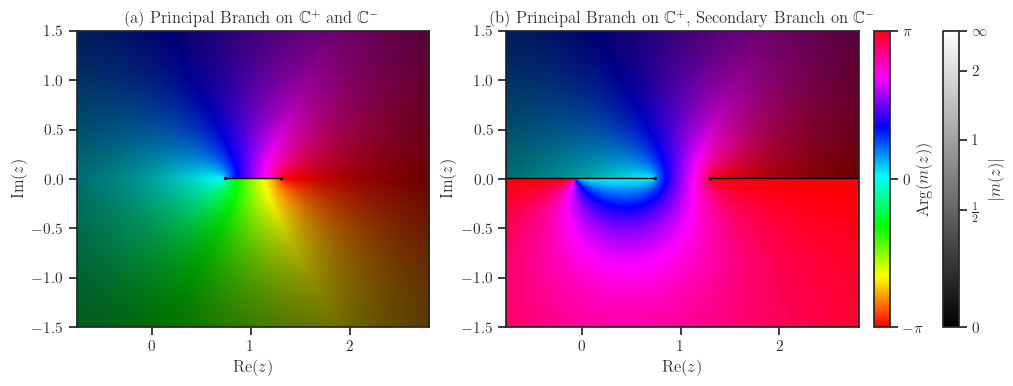

In [8]:
x = numpy.linspace(mp.lam_m-1.5, mp.lam_p+1.5, 300)
y = numpy.linspace(-1.5, 1.5, 200)

m1, m2 = ff.stieltjes(x, y, plot=True, latex=latex)

Now that everything looks to be in order, we can perform the free decompression algorithm to identify the spectral density of the enlarged matrix of size $100,000 \times 100,000$. This is achieved with the ``.decompress()`` procedure, and again, we can plot the resulting density. The procedure returns three objects: ``x``, the locations where the spectral density can be evaluated, ``rho`` the estimated spectral density on ``x``, and ``eigs`` the estimated resampled eigenvalues. If only the spectral density is required, the ``eigvals=False`` flag will prevent the resampling procedure.

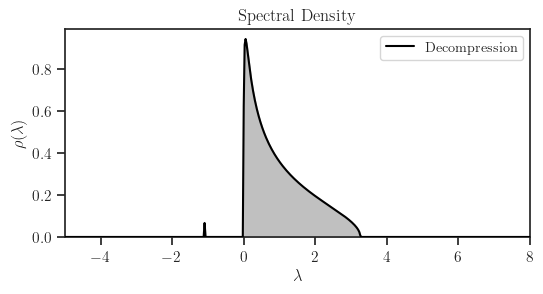

In [9]:
x, rho, eigs = ff.decompress(100_000, plot=True, latex=latex)